# Graph Convolutional Network Autoencoder Demonstration
The purpose of this notebook is to demonstrate a simple Graph Convolutional Network (GCN) Autoencoder model, trained on the QM9 molecular dataset. The model generates graphs which are visualized at the end of the notebook. This is only a demonstration of the technology, the graphs themselves are not intended for practical use.

## Load and prepare the data


In [1]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import pytorch_lightning as pl

# Load QM9 dataset
dataset = QM9(root='../../data/QM9')
len(dataset), dataset.num_features

(130831, 11)

## Explore the data

['edge_attr', 'y', 'smiles', 'z', 'idx', 'pos', 'name', 'x', 'edge_index']
Data(x=[9, 11], edge_index=[2, 18], edge_attr=[18, 4], y=[1, 19], pos=[9, 3], z=[9], smiles='[H]C1=NC([H])=C([H])N1[H]', name='gdb_51', idx=[1])
Edge indices: 
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 6, 7, 8],
        [1, 4, 5, 0, 2, 6, 1, 3, 7, 2, 4, 0, 3, 8, 0, 1, 2, 4]])
The shape of the edge index matrix is 2x(2*num_edges) because edges are bidirectional
The 50th graph has smiles:[H]C1=NC([H])=C([H])N1[H]
There are 9 nodes, each with 11 features per node
There are 9 bi-directional edges, with 4 attributes per edge
The graph has 19 targets/tasks, described in the paper
Edge attributes: 
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])
[single, double, triple, aromatic]


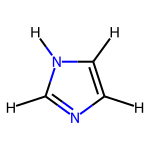

In [2]:
from torch_geometric.data import Data
i=50
datapoint = Data(x=dataset[i].x, 
            edge_index=dataset[i].edge_index,
            edge_attr=dataset[i].edge_attr,
            y=dataset[i].y,
            pos=dataset[i].pos,
            z=dataset[i].z,
            smiles=dataset[i].smiles,
            name=dataset[i].name,
            idx=dataset[i].idx
           )
print(datapoint.keys())
print(datapoint)
print(f"Edge indices: \n{datapoint.edge_index}")
print(f"The shape of the edge index matrix is 2x(2*num_edges) because edges are bidirectional")
print(f"The {i}th graph has smiles:{datapoint.smiles}")
print(f"There are {datapoint.x.shape[0]} nodes, each with {datapoint.x.shape[1]} features per node")
print(f"There are {datapoint.edge_index.shape[1]/2:.0f} bi-directional edges, with {datapoint.edge_attr.shape[1]} attributes per edge")
print(f"The graph has {datapoint.y.shape[1]} targets/tasks, described in the paper")
print(f"Edge attributes: \n{datapoint.edge_attr[0:int(datapoint.edge_index.shape[1]/2)]}")
print("[single, double, triple, aromatic]")
from rdkit import Chem
mol=Chem.MolFromSmiles(datapoint.smiles)
Chem.Draw.MolToImage(Chem.AddHs(mol), size=(150,150))


In [3]:
class MoleculeDataModule(pl.LightningDataModule):
    def __init__(self, dataset, train_batch_size=32, val_batch_size=32, train_val_split=0.8,
                 drop_last=True):
        super().__init__()
        self.dataset = dataset
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.train_val_split = train_val_split
        self.train_dataset = None
        self.val_dataset = None

    def setup(self, stage=None):
        # Split dataset into training and validation
        num_train = int(len(self.dataset) * (1 - self.train_val_split))
        self.train_dataset, self.val_dataset = self.dataset[:num_train], self.dataset[num_train:]

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.train_batch_size, shuffle=True, drop_last=True)
    def val_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.val_batch_size, shuffle=False, drop_last=False)


## Fit the model

Load the data batches, build the model, fit, and plot the train/validation losses.


In [6]:
%%time
from bd.models import GCNAutoencoder

BATCH_SIZE=64
HIDDEN_DIM=64
EPOCHS=3

data_module = MoleculeDataModule(dataset, train_batch_size=BATCH_SIZE, val_batch_size=BATCH_SIZE)
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

model = GCNAutoencoder(in_channels = dataset.num_features, hidden_dim=HIDDEN_DIM)
trainer = pl.Trainer(max_epochs=EPOCHS)#, callbacks=[data.CustomRichProgressBar()])  # Adjust according to your setup
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | GCNConv | 768   
1 | decoder | GCNConv | 715   
------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.


CPU times: user 2min 12s, sys: 10.8 s, total: 2min 22s
Wall time: 2min 21s


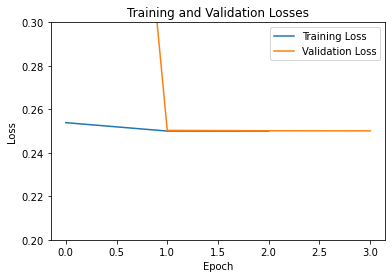

In [7]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(model.train_losses, label='Training Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.2,0.3)
plt.legend()
plt.show()


## Generate graphs

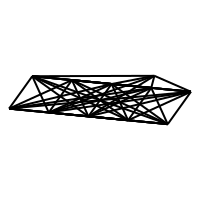

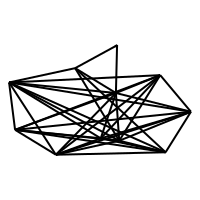

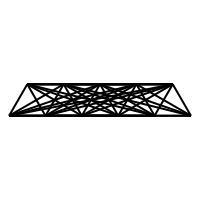

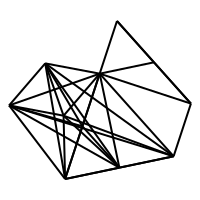

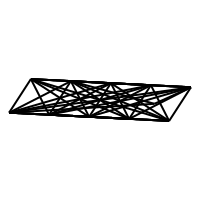

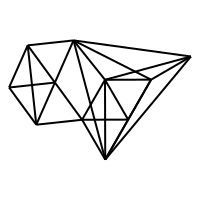

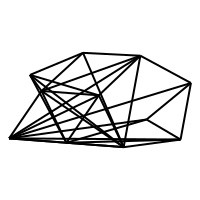

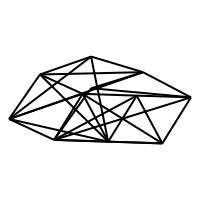

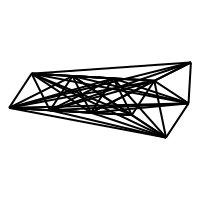

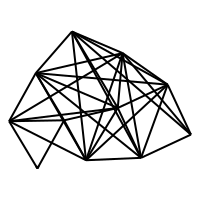

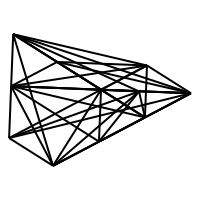

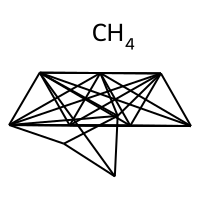

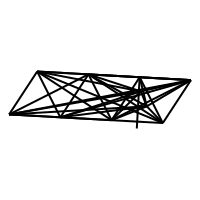

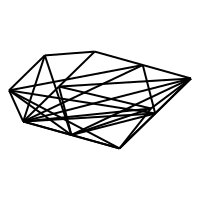

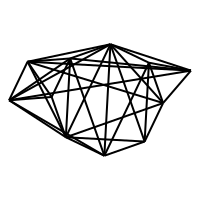

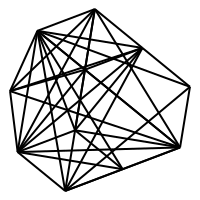

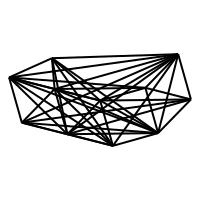

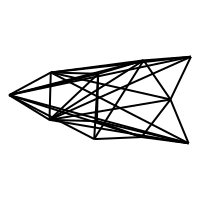

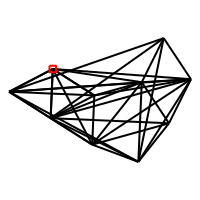

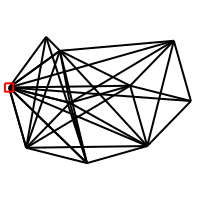

In [8]:
# Function to generate and display molecules
def generate_and_display_molecules(model, num_samples=5):
    # why does z need to be 64x11? 64=out_channels, but why 11? 
    from torch_geometric.data import Data
    from rdkit import Chem
    

    model.eval()
    with torch.no_grad():
        for _ in range(num_samples):
            # Sample random latent vector
            z = torch.randn(model.encoder.out_channels,11)  # Random latent vector
            dummy_edge_index = torch.LongTensor([[0], [0]])  # Minimal edge index
            data = Data(x=z, edge_index=dummy_edge_index)
            _, x_reconstructed = model(data)
            
            # Assuming all atoms are carbon and trying to visualize any possible bonds
            mol = Chem.RWMol()
            num_atoms = x_reconstructed.shape[1]
            for i in range(num_atoms):
                mol.AddAtom(Chem.Atom(6))  # Carbon atom
            
            # Generate some edges for visualization (simple heuristic)
            threshold = 0.5
            adj_matrix = torch.sigmoid(torch.mm(x_reconstructed, x_reconstructed.t())) > threshold
            for i in range(num_atoms):
                for j in range(i + 1, num_atoms):
                    if adj_matrix[i, j]:
                        mol.AddBond(i, j, Chem.BondType.SINGLE)

            # Visualize the molecule
            display(Chem.Draw.MolToImage(mol, size=(200, 200)))

# Example usage
generate_and_display_molecules(model,num_samples=20)
